In [28]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, PReLU, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [29]:
# Define la función FSRCNN
def FSRCNN(scale_factor, input_shape=(64, 64, 1)):
    inputs = Input(shape=input_shape)

    # Feature extraction
    x = Conv2D(64, (5, 5), padding='same')(inputs)
    x = PReLU()(x)
    
    # Shrinking
    x = Conv2D(16, (1, 1), padding='same')(x)
    x = PReLU()(x)
    
    # Non-linear mapping
    for _ in range(6):  # Aumentar el número de capas de mapeo no lineal
        x = Conv2D(16, (3, 3), padding='same')(x)
        x = PReLU()(x)
    
    # Expanding
    x = Conv2D(64, (1, 1), padding='same')(x)
    x = PReLU()(x)
    
    # Deconvolution
    x = Conv2DTranspose(1, (9, 9), strides=(scale_factor, scale_factor), padding='same')(x)
    outputs = PReLU()(x)
    
    model = Model(inputs, outputs)
    return model

# Crear el modelo FSRCNN
model = FSRCNN(scale_factor=4, input_shape=(64, 64, 1))  # Usar factor de escala 4 para 64x64 a 256x256
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

In [32]:

# Preparar datos para el entrenamiento
def load_dataset(low_res_dir, high_res_dir):
    low_res_images = []
    high_res_images = []

    for filename in os.listdir(low_res_dir):
        low_res_image_path = os.path.join(low_res_dir, filename)
        high_res_image_name = filename.split('_blur')[0].split('_64x64')[0] + '_256x256.png'
        high_res_image_path = os.path.join(high_res_dir, high_res_image_name)
        
        # Verificar si el archivo de alta resolución existe
        if os.path.exists(high_res_image_path):
            low_res_image = load_img(low_res_image_path, color_mode='grayscale')
            high_res_image = load_img(high_res_image_path, color_mode='grayscale')

            low_res_images.append(img_to_array(low_res_image) / 255.0)
            high_res_images.append(img_to_array(high_res_image) / 255.0)
        else:
            print(f"Archivo de alta resolución no encontrado para: {low_res_image_path}")

    return np.array(low_res_images), np.array(high_res_images)

# Cargar los datos
base_dir = r'C:\Users\lina-\Documents\ProyectoComputacion\Proyecto\dataset2'
x_train, y_train = load_dataset(os.path.join(base_dir, 'train/low_res'), os.path.join(base_dir, 'train/high_res'))
x_val, y_val = load_dataset(os.path.join(base_dir, 'validation/low_res'), os.path.join(base_dir, 'validation/high_res'))

# Asegurarse de que los datos tienen la forma correcta
x_train = x_train.reshape(-1, 64, 64, 1)
y_train = y_train.reshape(-1, 256, 256, 1)
x_val = x_val.reshape(-1, 64, 64, 1)
y_val = y_val.reshape(-1, 256, 256, 1)

In [34]:
# Callbacks para el entrenamiento
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [35]:

# Callback personalizado para monitorear PSNR y SSIM
class MonitorPSNRandSSIM(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MonitorPSNRandSSIM, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self.validation_data
        val_y_pred = self.model.predict(val_x)

        psnr_values = [psnr(val_y[i], val_y_pred[i], data_range=1.0) for i in range(len(val_y))]
        ssim_values = [ssim(val_y[i].reshape(256, 256), val_y_pred[i].reshape(256, 256), data_range=1.0) for i in range(len(val_y))]

        mean_psnr = np.mean(psnr_values)
        mean_ssim = np.mean(ssim_values)

        print(f"Epoch {epoch+1}: PSNR: {mean_psnr:.4f}, SSIM: {mean_ssim:.4f}")

In [40]:
# Entrenar el modelo con más información
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,  # Aumentar el número de épocas
    batch_size=16,
    callbacks=[tensorboard_callback, checkpoint_callback, MonitorPSNRandSSIM((x_val, y_val))]
)

Epoch 1/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0024
Epoch 1: val_loss improved from 0.00250 to 0.00242, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Epoch 1: PSNR: 26.7089, SSIM: 0.7727
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 2/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0025
Epoch 2: val_loss improved from 0.00242 to 0.00234, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
Epoch 2: PSNR: 26.8374, SSIM: 0.7772
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 3/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0023
Epoch 3: val_loss did not improve from 0.00234
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Epoch 3: PSNR: 26.7821, SSIM: 0.7793
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 4/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0023
Epoch 4: val_loss did not improve from 0.00234
9/9 ━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.0019
Loss en el conjunto de prueba: 0.0018330757739022374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


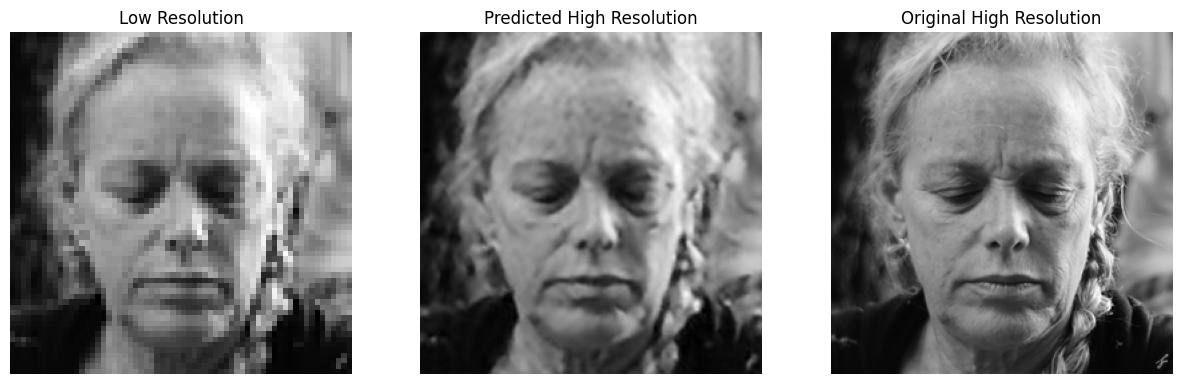

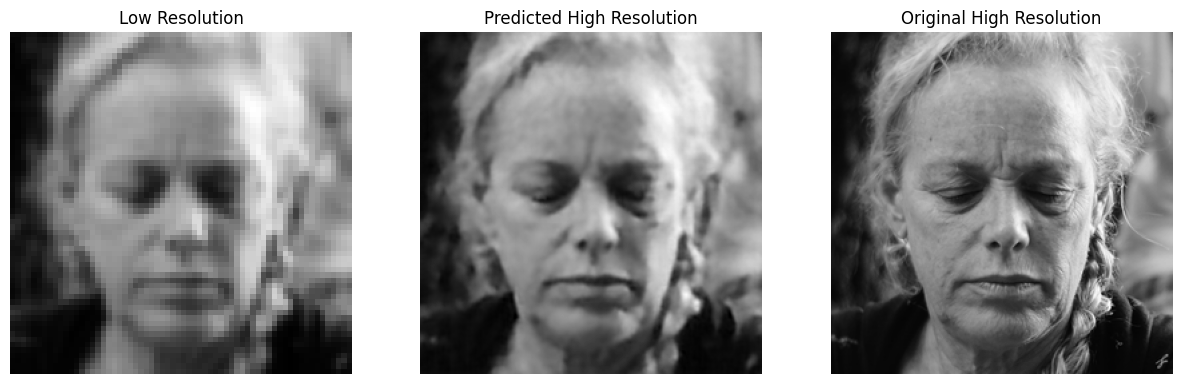

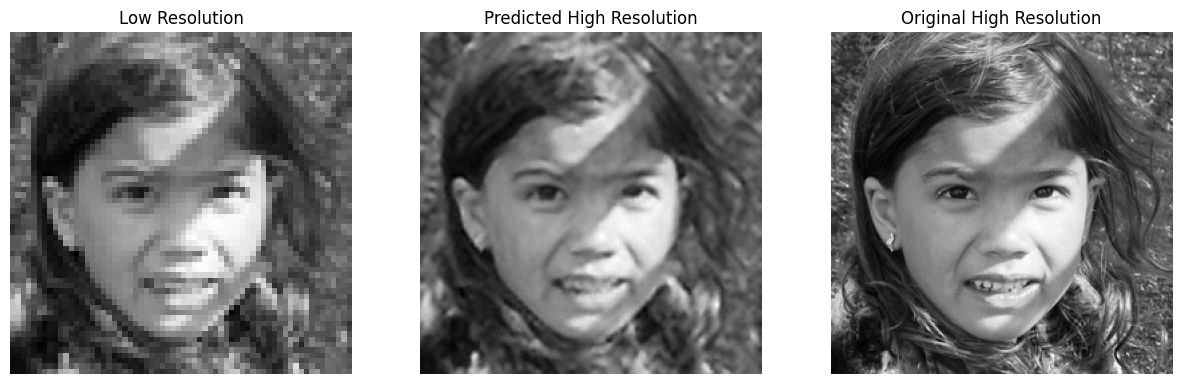

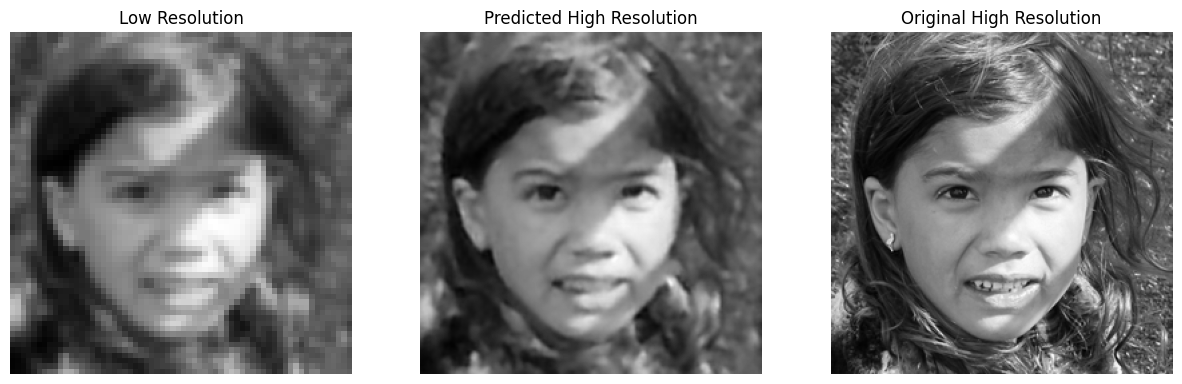

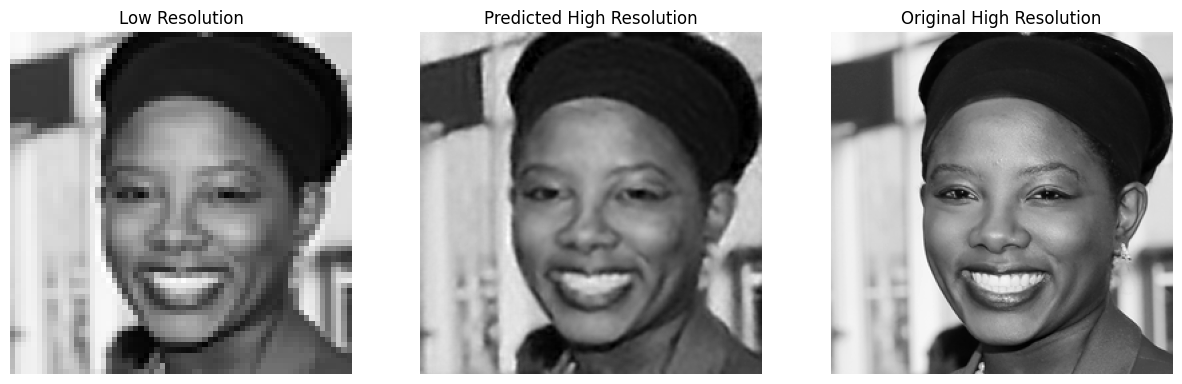

In [41]:
# Evaluar el modelo y mostrar resultados
x_test, y_test = load_dataset(os.path.join(base_dir, 'test/low_res'), os.path.join(base_dir, 'test/high_res'))
x_test = x_test.reshape(-1, 64, 64, 1)
y_test = y_test.reshape(-1, 256, 256, 1)
loss = model.evaluate(x_test, y_test)
print(f'Loss en el conjunto de prueba: {loss}')

# Función para predecir y mostrar resultados
def predict_and_show(model, x_test, y_test, num_images=5):
    predictions = model.predict(x_test[:num_images])

    for i in range(num_images):
        low_res_image = x_test[i].reshape(64, 64)
        high_res_image = y_test[i].reshape(256, 256)
        predicted_image = predictions[i].reshape(256, 256)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Low Resolution')
        plt.imshow(low_res_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Predicted High Resolution')
        plt.imshow(predicted_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Original High Resolution')
        plt.imshow(high_res_image, cmap='gray')
        plt.axis('off')

        plt.show()

# Predecir y mostrar resultados
predict_and_show(model, x_test, y_test, num_images=5)

In [42]:
# Guardar el modelo entrenado al final del entrenamiento
model.save('fsrcnn_model_v2.h5')
